# GPU accelerated evaluation of particle sums

## Background

In this notebook we want to implement the GPU accelerated evaluation of particle sums. We are given targets $x_i\in\mathbb{R}^3$ and sources $y_j\in\mathbb{R}^3$. The task is to evaluate the sum

$$
f(x_i) = \sum_{j} g(x_i, y_j) c_j
$$

for given weights $c_j\in\mathbb{C}$. Here, $g(x_i, y_j)$ is a given function depending on $x_i$ and $y_j$. Examples include

* **The electrostatic potential** $g(x, y) = \frac{1}{4\pi|x - y|}$
* **The acoustic Green's function** $g(x, y) = \frac{e^{ik|x-y|}}{4\pi|x-y|}$
* **The radial basis function (RBF) kernel** $g(x, y) = e^{-\frac{|x- y|^2}{2\sigma^2}}$

The parameter $k$ is called the spatial wavenumber and $\sigma$ is a scaling factor.

In the following we implement a GPU evaluation of the direct sum for the RBF kernel. RBF kernels are frequently used in machine learning. If we have $M$ targets and $N$ sources the overall complexity of the evaluation is $O(MN)$.

## A CPU implementation

We first write a parallel CPU implementation for comparison

In [9]:
import numpy as np
import numba

sigma = .1

@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

Let us test this implementation. We choose sources randomly in the unit box $[0, 1]^3$ and as targets we pick points in a grid along the three planes $xy$, $xz$ and $zy$.

In [10]:
npoints = 400
nsources = 50

plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)

# We are picking random sources

sources = rand.rand(nsources, 3)


Let us run the code and visualize the result using random weights.

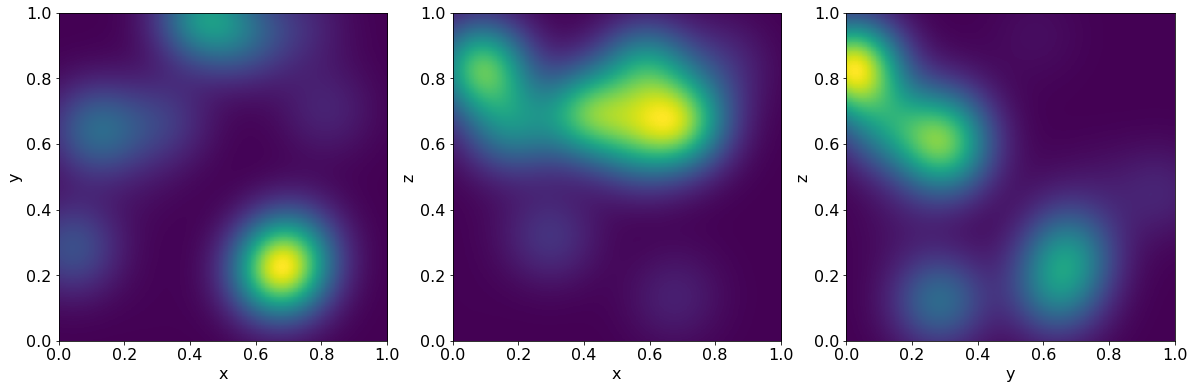

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.size"] = 16

result = np.zeros(len(targets), dtype=np.float64)

weights = rand.rand(len(sources))

rbf_evaluation(sources, targets, weights, result)

def visualize(result, npoints):
    """A helper function for visualization"""
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')

    
    
visualize(result, npoints)

## A parallel CUDA implementation

We will now implement a CUDA version of this code. We assume that we have many more evaluation points than sources for the subsequent code. Each thread block will perform the evaluation for a small chunk of the target points and all source points. This strategy will not work if we have as many sources as there are targets.

In [12]:
import numba
from numba import cuda
import math


SX = 16
SY = nsources



@cuda.jit
def rbf_evaluation_cuda(sources, targets, weights, result):
    local_result = cuda.shared.array((SX, nsources), numba.float32)
    local_targets = cuda.shared.array((SX, 3), numba.float32)
    local_sources = cuda.shared.array((SY, 3), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[ty]
        
    # Let us now sync all threads
    
    cuda.syncthreads()
    
    # Now compute the interactions
    
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    
    if ty == 0:
        res = numba.float32(0)
        for index in range(nsources):
            res += local_result[tx, index]
        result[px] = res    

In [13]:
nblocks = (targets.shape[0] + SX - 1) // SX
result = np.zeros(len(targets), dtype=np.float32)
rbf_evaluation_cuda[(nblocks, 1), (SX, SY)](sources.astype('float32'), targets.astype('float32'), weights.astype('float32'), result)

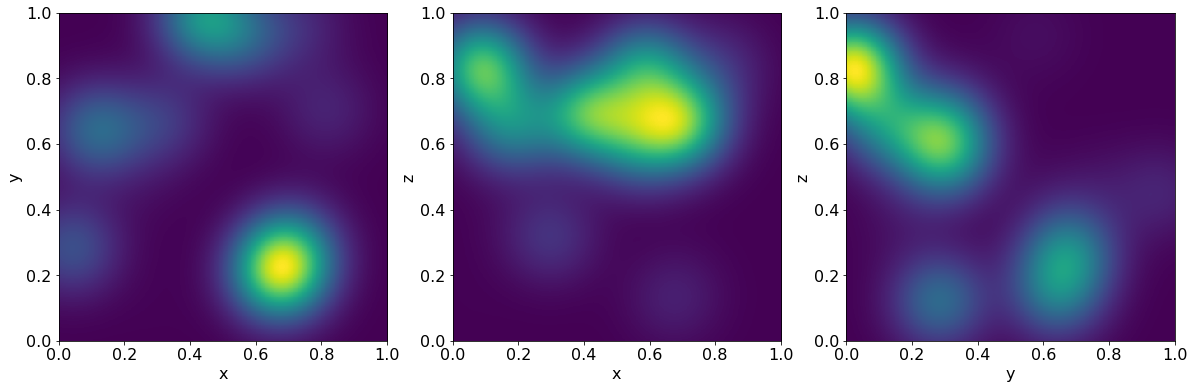

In [14]:
visualize(result, npoints)

Now let us benchmark the two versions against each other.

In [15]:
%timeit rbf_evaluation_cuda[(nblocks, 1), (SX, SY)](sources.astype('float32'), targets.astype('float32'), weights.astype('float32'), result)

9.09 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit rbf_evaluation(sources, targets, weights, result)

225 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Cuda implementation is on my laptop around 40 times faster than the parallel CPU implementation.